In [23]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime
from scipy.fft import fft, fftfreq,rfft2

import scipy.signal as signal
from obspy.signal import filter as obsfilt
import glob


In [2]:
WEAK = False

x_len = 5000
t_len = 6000

xs = np.arange(x_len)
dt = 1

library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]  

if WEAK:
    X, T = np.meshgrid(xs, np.arange(t_len))
    XT = np.asarray([X, T]).T

    pde_lib = ps.WeakPDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=4,
        spatiotemporal_grid=XT,
        is_uniform=True,
        K=1000,
    )
else:
    
    pde_lib = ps.PDELibrary(
        library_functions=library_functions,
        function_names=library_function_names,
        derivative_order=4,
        spatial_grid=xs,
        include_bias=True,
        is_uniform=True,
    )
    

## Unfiltered

In [28]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

init = 11
final= 16

time_subsample = 10
full_dat = np.zeros((5000,(12000//time_subsample)*(final-init)))

k = 0
for i in np.arange(init,final):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    
working_dat = full_dat/np.std(full_dat)


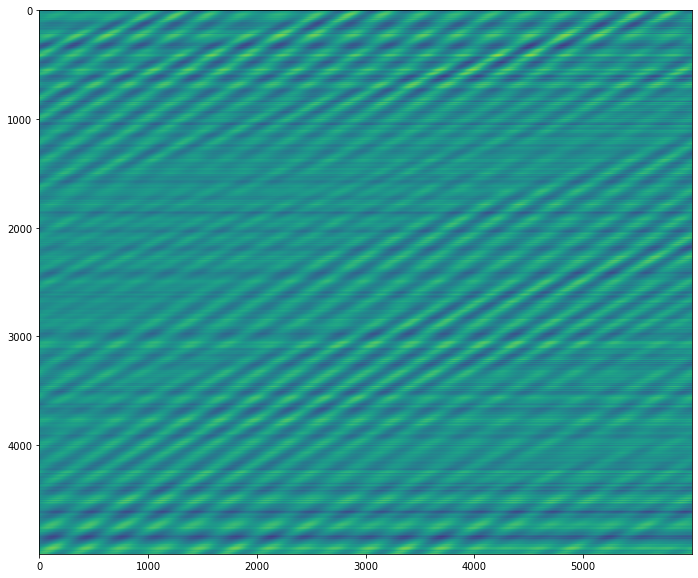

In [29]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat, vmin=-5.,vmax=5.)
plt.show()

In [5]:

working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)


### Dataset 1

In [6]:
thresh = 1e-4
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fe3f2f395b0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.0001))

In [7]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.0001
(x0)' = 0.005 x0_1 + 0.003 x0_111


In [8]:
thresh = 1e-6
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fe3f2f395b0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1e-06))

In [9]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1e-06
(x0)' = 0.005 x0_1 + 0.003 x0_111


In [10]:
thresh = 1e-8
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fe3f2f395b0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1e-08))

In [11]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1e-08
(x0)' = 0.005 x0_1 + 0.003 x0_111


### Dataset 2

In [24]:
time_subsample = 10
full_dat = np.zeros((5000,6000))

k = 0
for i in np.arange(21,26):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T23"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    
    full_dat[:,k*(12000//time_subsample):(k+1)*(12000//time_subsample)] = data[7500:12500,::time_subsample]
    k+=1
    


In [25]:
working_dat = full_dat/np.std(full_dat)#*10**6
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)


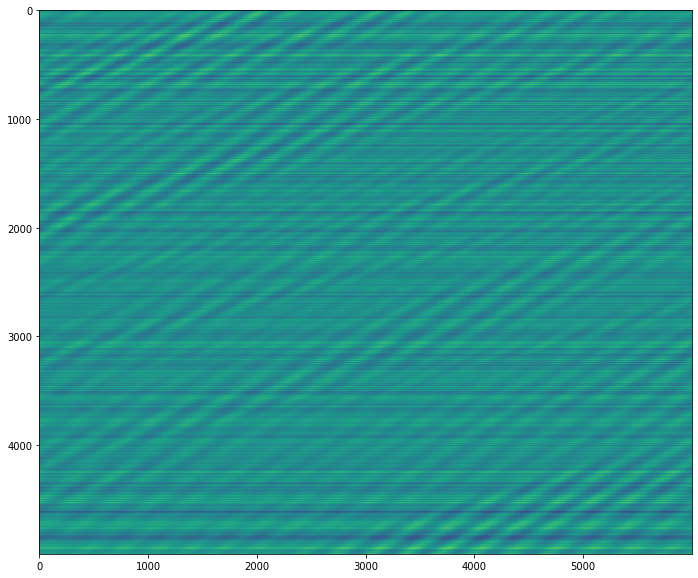

In [27]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0], vmin=-5.,vmax=5.)
plt.show()

In [15]:
thresh = 1e-4
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fe3f2f395b0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.0001))

In [16]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.0001
(x0)' = 0.001 x0_1 + 0.001 x0_111


In [17]:
thresh = 1e-6
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fe3f2f395b0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1e-06))

In [18]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1e-06
(x0)' = 0.001 x0_1 + 0.001 x0_111


In [19]:
thresh = 1e-8
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fe3f2f395b0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1e-08))

In [20]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1e-08
(x0)' = 0.001 x0_1 + 0.001 x0_111


## Gaussian Filtered



In [21]:
file_list = glob.glob("/home/ldoyle/notebooks/rad_10_smooth_data/*")

In [22]:
# n = 1.4682
# L = 51.04762
working_dat = np.zeros((5000,6000))
b=0
for q in np.arange(5):
#     if b==0:
#         working_dat = np.load(file_list[q])
#         b=1
#     else:
#         working_dat = np.hstack((working_dat, np.load(file_list[q])))
    working_dat[:,q*(1200):(q+1)*1200] = np.load(file_list[q])[:,::10]
        
# working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat[:,::10]
working_dat = working_dat/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

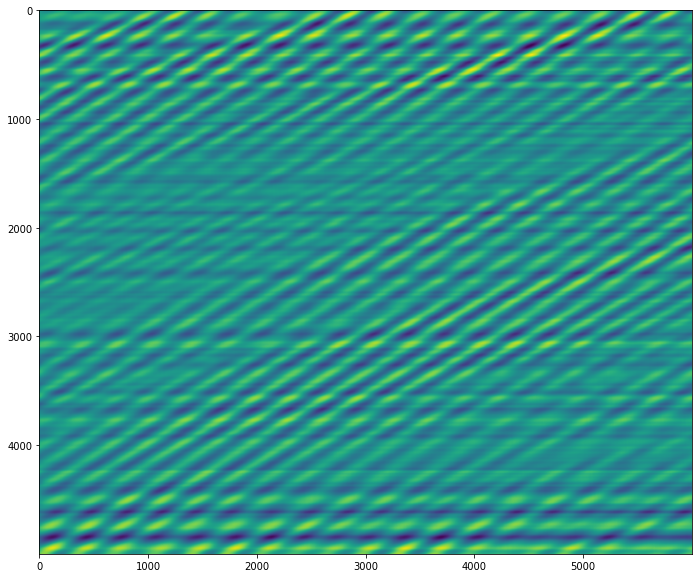

In [23]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0])
plt.show()

In [24]:
xs = np.arange(working_dat.shape[0])
print(xs.shape)

(5000,)


### Dataset 1

In [25]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fe3f2f395b0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1.0))

In [26]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = -6.298 x0_111


In [27]:
thresh = 0.4
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fe3f2f395b0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.4))

In [28]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.4
(x0)' = -6.782 x0_111 + 0.423 x0x0x0_111


In [29]:
thresh = 0.2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fe3f2f395b0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.2))

In [30]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.2
(x0)' = 0.431 x0_1 + 18.967 x0_111 + 0.604 x0x0x0_111


In [31]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fe3f2f395b0>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=100))

In [32]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.431 x0_1 + 18.948 x0_111 + -0.609 x0x0_111 + 0.597 x0x0x0_111


### Dataset 2

In [33]:
working_dat = np.zeros((5000,6000))
b=0
for q in np.arange(10,15):

    working_dat[:,b*(1200):(b+1)*1200] = np.load(file_list[q])[:,::10]
    b+=1
# working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat[:,::10]
working_dat = working_dat/(np.std(working_dat))
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)

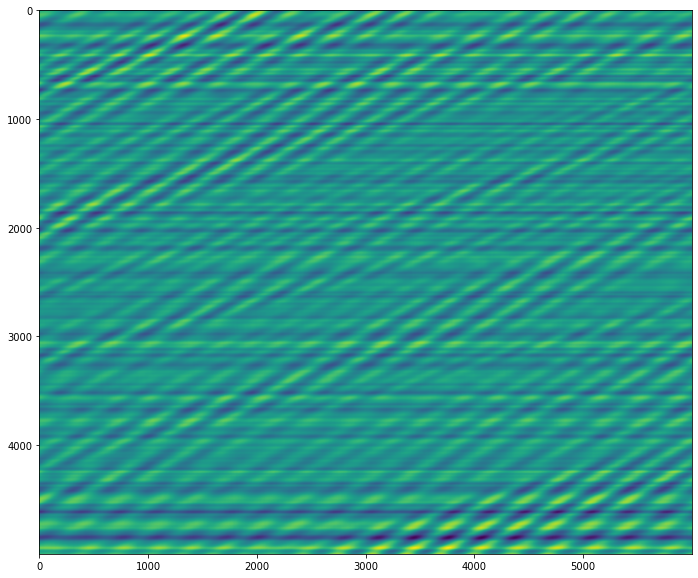

In [34]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0])
plt.show()

In [35]:
thresh = 1.
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (1.0) and eliminated all coefficients
  warnings.warn(
/home/ldoyle/packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity param

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fe3f2f395b0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=1.0))

In [36]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 1.0
(x0)' = 0.000


In [37]:
thresh = 0.4
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

/home/ldoyle/packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.4) and eliminated all coefficients
  warnings.warn(


SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fe3f2f395b0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.4))

In [38]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.4
(x0)' = -1.154 x0_111


In [39]:
thresh = 0.2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fe3f2f395b0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.2))

In [40]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.2
(x0)' = 0.275 x0_1 + 12.396 x0_111 + 0.150 x0x0x0_111


In [41]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fe3f2f395b0>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=100))

In [42]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.275 x0_1 + 12.396 x0_111 + 0.150 x0x0x0_111


## Drift Removal Load

In [24]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy")[:,::10]
scaler_val = np.std(working_dat)
working_dat = working_dat/scaler_val
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])

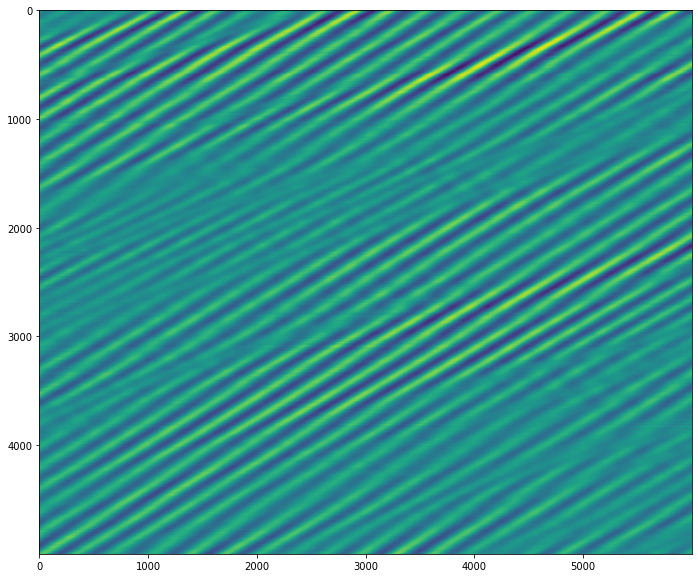

In [26]:
plt.figure(figsize=(12,10))
plt.imshow(working_dat[:,:,0])
plt.show()

In [77]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.01))

In [78]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.221 x0_1 + 0.103 x0_111


In [79]:
thresh = 0.005
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.005))

In [80]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.005
(x0)' = 0.221 x0_1 + 0.103 x0_111


In [81]:
thresh = 2e-3
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.002))

In [82]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.002
(x0)' = 0.232 x0_1 + 0.109 x0_111 + -0.009 x0x0x0_1 + -0.004 x0x0x0_111


### Dataset 2

In [19]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T232114Z.npy")[:,::10]
scaler_val = np.std(working_dat)
working_dat = working_dat/scaler_val
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)
xs = np.arange(working_dat.shape[0])

In [21]:
thresh = 0.095
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7f059e1763a0>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.095))

In [22]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.095
(x0)' = 0.216 x0_1 + 0.100 x0_111


In [84]:
thresh = 0.01
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.01))

In [85]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.145 x0_1 + 0.068 x0_111


In [90]:
thresh = 5e-3
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.005))

In [91]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.005
(x0)' = 0.145 x0_1 + 0.068 x0_111


In [88]:
thresh = 0.002
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.002))

In [89]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.002
(x0)' = 0.157 x0_1 + 0.075 x0_111 + -0.008 x0x0x0_1 + -0.005 x0x0x0_111


## Multifilt

In [93]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/rad_4_smoothed_decimated_normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T051114Z.npy")
scaler_val = np.std(working_dat)
working_dat = working_dat/scaler_val
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)


### Dataset 1

In [96]:
thresh = 5e-1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.5))

In [97]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.5
(x0)' = 0.568 x0_1 + 3.874 x0_111


In [98]:
thresh = 1e-1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=100))

In [99]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.568 x0_1 + 3.828 x0_111 + 0.033 x0x0x0_111


In [100]:
thresh = 5e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.05))

In [101]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.05
(x0)' = 0.568 x0_1 + 3.828 x0_111 + 0.033 x0x0x0_111


In [110]:
thresh = 3e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.03))

In [111]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.03
(x0)' = 0.568 x0_1 + 3.828 x0_111 + -0.008 x0_1111 + 0.033 x0x0x0_111


### Dataset 2

In [116]:
working_dat = np.load("/home/ldoyle/notebooks/channel_drift_5_min_clips/rad_4_smoothed_decimated_normalized_5_min_start_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T231114Z.npy")
scaler_val = np.std(working_dat)
working_dat = working_dat/scaler_val
working_dat = working_dat.reshape(working_dat.shape[0],working_dat.shape[1],1)


In [117]:
thresh = 5e-1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.5))

In [118]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.5
(x0)' = 0.514 x0_1 + 3.516 x0_111


In [119]:
thresh = 0.1
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'], optimizer=STLSQ(alpha=0.001, max_iter=100))

In [120]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.1
(x0)' = 0.514 x0_1 + 3.516 x0_111


In [123]:
thresh = 5e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.05))

In [124]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.05
(x0)' = 0.514 x0_1 + 3.499 x0_111 + 0.013 x0x0x0_111


In [121]:
thresh = 3e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)


# library_ensemble_coefs = model.coef_list
# mean_library_ensemble = np.mean(library_ensemble_coefs, axis=0)
# std_library_ensemble = np.std(library_ensemble_coefs, axis=0)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.03))

In [122]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.03
(x0)' = 0.514 x0_1 + 3.499 x0_111 + 0.013 x0x0x0_111 + -0.002 x0x0_1111


In [47]:
thresh = 1e-2
optimizer = ps.STLSQ(threshold=thresh, alpha=0.001, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(working_dat, t=dt,ensemble=True)

SINDy(differentiation_method=FiniteDifference(axis=1),
      feature_library=<pysindy.feature_library.pde_library.PDELibrary object at 0x7fdc84057940>,
      feature_names=['x0'],
      optimizer=STLSQ(alpha=0.001, max_iter=100, threshold=0.01))

In [48]:
print("Ensemble STLSQ with Threshold "+str(thresh))
model.print()
#beginning data

Ensemble STLSQ with Threshold 0.01
(x0)' = 0.572 x0_1 + 3.842 x0_111 + 0.002 x0_1111 + 0.014 x0x0x0_111 + -0.002 x0x0x0_1111
